# Classification de biais politique
* Test sur 10000 articles sur le thème "election"
* Dataset réduit aux labels, sources, titres et textes avec bert-base
* Mise en place suivant les indications de https://huggingface.co/docs/transformers/v4.35.2/en/training et le tp de TAL.

-----
##Imports usuels

In [ ]:
!pip install transformers[torch]
!pip install evaluate
!pip install datasets
!pip install huggingface_hub
!pip install transformers_interpret

In [2]:
import datasets
import torch
import numpy as np
import evaluate
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from transformers_interpret import SequenceClassificationExplainer, TokenClassificationExplainer

## Récupérations et préparation des données

In [5]:
##-- Récuperer l'extrait de données np-elec-10k
!wget "https://drive.google.com/uc?export=download&id=17I64kNNUbAyqpEr7lE8eEEfXd7L0NI_r" -O "np-elec-10k.csv"

--2024-02-22 08:29:07--  https://drive.google.com/uc?export=download&id=17I64kNNUbAyqpEr7lE8eEEfXd7L0NI_r
Resolving drive.google.com (drive.google.com)... 142.251.175.139, 142.251.175.101, 142.251.175.100, ...
Connecting to drive.google.com (drive.google.com)|142.251.175.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=17I64kNNUbAyqpEr7lE8eEEfXd7L0NI_r&export=download [following]
--2024-02-22 08:29:07--  https://drive.usercontent.google.com/download?id=17I64kNNUbAyqpEr7lE8eEEfXd7L0NI_r&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.4.132, 2404:6800:4003:c06::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.4.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51058529 (49M) [application/octet-stream]
Saving to: ‘np-elec-10k.csv’

np-elec-10k.csv     100%[===================>]  48.69M  46.2M

In [6]:
##--Importer les données dans un dataframe pandas

df = pd.read_csv("np-elec-10k.csv")  #dispo sur le drive

##--Renommer les colonnes qu'on va utiliser
df = df.rename(columns={ 'Allside': 'labels' })
df = df.rename(columns={ 'highlight.maintext': 'text' })
df = df.rename(columns={ '_source.title': 'title' })
df = df.rename(columns={'_source.source_domain': 'source'})

##--Selectionner les colonnes en question dans un nouveau dataframe
df2 = df[['labels','source','title','text']]

##--Supprimer les labels '?'
df3 = df2[df2['labels'] != '?']

##--Rennommer les labels avec des ints pour faciliter l'utilisation
correspondance = {"Left" :0, "Lean Left" :0, "Center" :1, "Lean Right" :2, "Right" :2, "Mixed" :1}
df3['labels'] = df3['labels'].replace(correspondance)

<ipython-input-6-6f9b88f4d4bc>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['labels'] = df3['labels'].replace(correspondance)


In [7]:
 ##-- Trouver les sources uniques dans le DataFrame
sources_uniques = df3['source'].unique()

##- Diviser la liste des sources de manière aléatoire en deux ensembles
sources_train, sources_test = train_test_split(sources_uniques, test_size=0.2, random_state=20)

##-- Filtrer les données en fonction des ensembles de sources
train_df = df3[df3['source'].isin(sources_train)]
test_df = df3[df3['source'].isin(sources_test)]

train_df2 = train_df[['labels','text']]
test_df2 = test_df[['labels','text']]

##--Separer les données dans des fichiers train et test
train_dataset = datasets.Dataset.from_pandas(train_df2)
test_dataset = datasets.Dataset.from_pandas(test_df2)

train_dataset = train_dataset.remove_columns(["__index_level_0__"])
test_dataset = test_dataset.remove_columns(["__index_level_0__"])

##-- Exporter en csv pour verifier le ontenu des datasets
# train.to_csv('./splitm-elec/train.csv')
# test.to_csv('./splitm-elec/test.csv')

dataset = datasets.DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

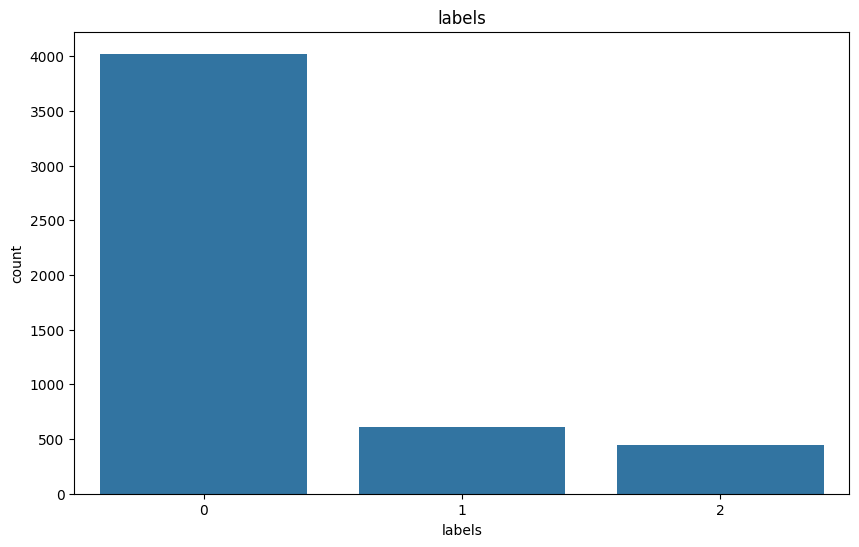

In [9]:
# affichage des données dans le train par classement de la colonne 'labels'
plt.figure(figsize=(10, 6))
sns.countplot(x='labels',  data=train_df2)
plt.title('labels')
plt.show()

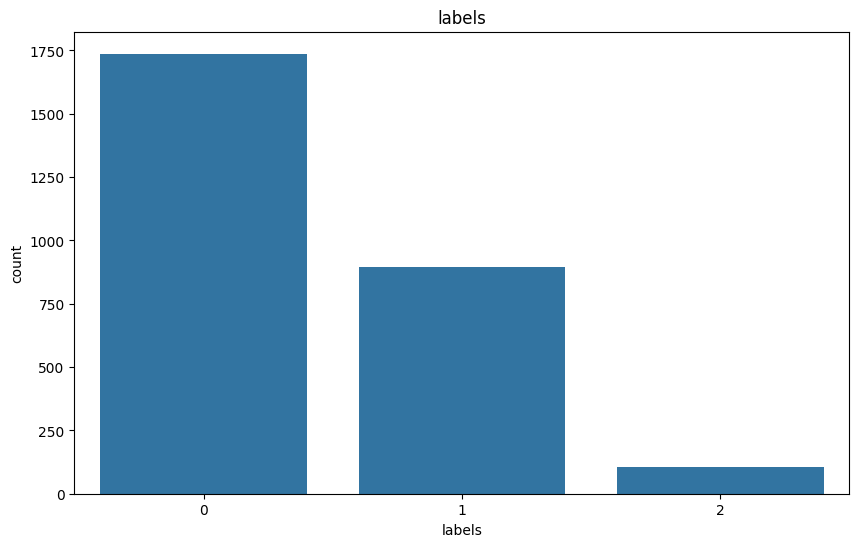

In [10]:
# affichage des données dans le test par classement de la colonne 'labels'
plt.figure(figsize=(10, 6))
sns.countplot(x='labels',  data=test_df2)
plt.title('labels')
plt.show()

In [16]:
##-- Tokenisation

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(4000)) #Modifiez la range si vous voulez réduire le temps de training [0:6613]
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000)) # [0:1202]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/5075 [00:00<?, ? examples/s]

Map:   0%|          | 0/2740 [00:00<?, ? examples/s]

## Modele et entrainement

In [17]:
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=6)
training_args = TrainingArguments(output_dir="test_trainer")
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="test_trainer",
    evaluation_strategy="epoch",
    num_train_epochs=10
    )

trainer = Trainer(

    model=model,

    args=training_args,

    train_dataset=small_train_dataset,

    eval_dataset=small_eval_dataset,

    compute_metrics=compute_metrics,
)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.529100,1.426798,0.610000
2,0.370600,1.705252,0.610000
3,0.269100,2.300724,0.605000


## Sauvegarder le modèle

In [ ]:
from pathlib import Path

MODEL_PATH = Path("model")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "classif_biais_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

## Tester le modèle

In [ ]:
##-- Erreurs de prédiction

pred, p_labels, metrics = trainer.predict(small_eval_dataset)

q = 0
distance = []
a = []
t = len(small_eval_dataset[:]["labels"])
for i in range(len(small_eval_dataset[:]["labels"])):
  p = np.argmax(pred[i])
  a.append(p)
  if small_eval_dataset[i]["labels"] != p:
    q = q+1
    distance.append(np.abs(small_eval_dataset[i]["labels"]-p))
    print('texte n°: ',i,', label gold: ',small_eval_dataset[i]["labels"],', label predit:', p, 'distance:', np.abs(small_eval_dataset[i]["labels"]-p))

print("ratio: ",q,"/",t)
print("distance moyenne des erreurs :", np.mean(distance),"(sur 3 classes)")

texte n°:  2 , label gold:  1 , label predit: 0 distance: 1
texte n°:  3 , label gold:  1 , label predit: 0 distance: 1
texte n°:  5 , label gold:  0 , label predit: 2 distance: 2
texte n°:  11 , label gold:  1 , label predit: 0 distance: 1
texte n°:  17 , label gold:  2 , label predit: 0 distance: 2
texte n°:  21 , label gold:  1 , label predit: 0 distance: 1
texte n°:  23 , label gold:  1 , label predit: 0 distance: 1
texte n°:  24 , label gold:  1 , label predit: 0 distance: 1
texte n°:  27 , label gold:  1 , label predit: 0 distance: 1
texte n°:  28 , label gold:  1 , label predit: 0 distance: 1
texte n°:  31 , label gold:  1 , label predit: 0 distance: 1
texte n°:  38 , label gold:  1 , label predit: 0 distance: 1
texte n°:  41 , label gold:  1 , label predit: 0 distance: 1
texte n°:  42 , label gold:  1 , label predit: 0 distance: 1
texte n°:  46 , label gold:  1 , label predit: 0 distance: 1
texte n°:  51 , label gold:  1 , label predit: 0 distance: 1
texte n°:  54 , label gold:

In [ ]:
# affichage des labels prédits
df = pd.DataFrame(a)
plt.figure(figsize=(10, 6))
sns.countplot(x=df[0],  data=df)
plt.title('labels prédits')
plt.show()